# Libraries & **Dependancies**


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Image Pre-Processing

## Yawn

In [2]:
def yawn_faces(direc="/content/drive/MyDrive/Training Data/Data/train", face_cas_path="/content/drive/MyDrive/Training Data/Prediction Images/haarcascade_frontalface_default.xml"):
    yawn = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yawn.append([resized_array, class_num1])
    return yawn


yawn_no_yawn = yawn_faces()

0
1


# Eyes 

In [3]:
def get_data(dir_path="/content/drive/MyDrive/Training Data/Data/train", face_cas="/content/drive/MyDrive/Training Data/Prediction Images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [4]:
data_train = get_data()

2
3


# Extend Data

In [5]:
def append_data():
#     total_data = []
    yawn = yawn_faces()
    data = get_data()
    yawn.extend(data)
    return np.array(yawn)

# New Variable to Store

In [6]:
new_data = append_data()

0
1
2
3


<ipython-input-5-ddf30c233450>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yawn)


# Labels and Features


In [7]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# Reshape Array


In [8]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

Conversion of Multiclass labels to Binary Labels

In [9]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [10]:
y = np.array(y)

In [11]:
X.shape

(1931, 145, 145, 3)

# Data Sets (Train & Data)

In [12]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [13]:
X_train.shape

(1351, 145, 145, 3)

In [14]:
len(X_train)

1351

# Randomize Training Images


In [15]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Training Model

In [16]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

# New Section

In [17]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/30
43/43 [==============================] - 384s 9s/step - loss: 1.1146 - accuracy: 0.5204 - val_loss: 0.5552 - val_accuracy: 0.7690
Epoch 2/30
43/43 [==============================] - 380s 9s/step - loss: 0.5223 - accuracy: 0.7905 - val_loss: 0.3934 - val_accuracy: 0.8655
Epoch 3/30
43/43 [==============================] - 379s 9s/step - loss: 0.3871 - accuracy: 0.8357 - val_loss: 0.3254 - val_accuracy: 0.8793
Epoch 4/30
43/43 [==============================] - 378s 9s/step - loss: 0.3287 - accuracy: 0.8616 - val_loss: 0.2885 - val_accuracy: 0.8414
Epoch 5/30
43/43 [==============================] - 378s 9s/step - loss: 0.3077 - accuracy: 0.8675 - val_loss: 0.2045 - val_accuracy: 0.9276
Epoch 6/30
43/43 [==============================] - 378s 9s/step - loss: 0.2442 - accuracy: 0.8986 - val_loss: 0.1754 - val_accuracy: 0.9362
Epoch 7/30
43/43 [==============================] - 377s 9s/step - loss: 0.2443 - accuracy: 0.8993 - val_loss: 0.1792 - val_accuracy: 0.9345
Epoch 8/30
43

# Model Performance

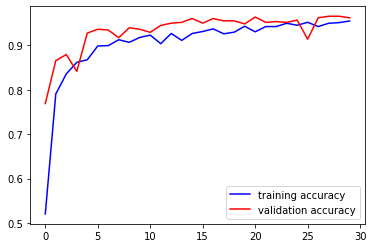

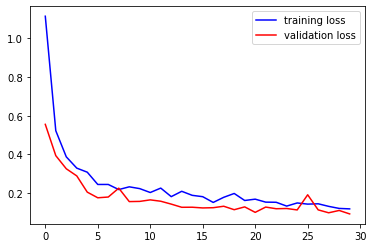

In [18]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [19]:
model.save("drowsiness_new.h5",overwrite=True)

In [20]:
prediction=np.argmax(model.predict(X_test), axis=1)
prediction

19/19 [==============================] - 37s 2s/step


array([2, 3, 3, 2, 1, 1, 3, 1, 2, 2, 0, 3, 2, 1, 2, 3, 1, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 3, 1, 1, 2, 2, 1, 3, 1, 0, 1, 3, 3, 3, 2, 3, 2, 2, 0,
       3, 2, 2, 2, 2, 3, 2, 3, 3, 0, 3, 3, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2,
       2, 1, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 0, 2, 2, 2, 2, 2,
       3, 3, 3, 2, 2, 3, 2, 1, 3, 1, 3, 3, 1, 0, 3, 1, 1, 3, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 0, 0, 3, 2, 3, 2, 2, 2, 2, 3, 3, 1, 3, 3, 2, 1, 2,
       3, 2, 3, 2, 1, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3, 2, 3, 0, 3, 3, 2,
       2, 3, 0, 2, 0, 3, 0, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 1, 2, 0, 3, 3, 2, 3, 0, 2, 2,
       0, 3, 3, 2, 2, 2, 0, 0, 3, 3, 3, 3, 1, 1, 1, 2, 2, 3, 2, 3, 3, 2,
       3, 2, 0, 1, 3, 3, 3, 3, 0, 3, 3, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 0,
       0, 1, 1, 2, 3, 3, 3, 2, 1, 2, 2, 3, 2, 1, 0, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 0, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 0, 3, 0, 1, 2, 3, 3,
       2, 1, 1, 2, 3, 2, 2, 3, 0, 2, 2, 2, 3, 3, 3,

In [21]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [22]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.95      0.62      0.75        64
     no_yawn       0.81      0.69      0.75        75
      Closed       0.84      0.97      0.90       214
        Open       0.94      0.94      0.94       227

    accuracy                           0.89       580
   macro avg       0.89      0.81      0.84       580
weighted avg       0.89      0.89      0.88       580



In [23]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/content/drive/MyDrive/Training Data/Prediction Images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowsiness_new.h5")

# Testing the Model


0. Yawn  
1. No yawn  
2. Closed Eyes
3. Open Eyes  



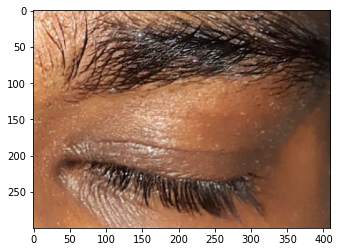

In [24]:
plt.imshow(plt.imread("/content/drive/MyDrive/Training Data/test/test/Closed/_363.jpg"))
plt.show()

In [25]:
prediction = model.predict([prepare("/content/drive/MyDrive/Training Data/test/test/Closed/_363.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 183ms/step


2

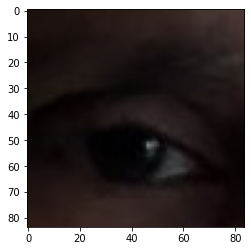

In [26]:
plt.imshow(plt.imread("/content/drive/MyDrive/Training Data/test/test/Open/_326.jpg"))
plt.show()

In [27]:
prediction = model.predict([prepare("/content/drive/MyDrive/Training Data/test/test/Open/_326.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 101ms/step


3

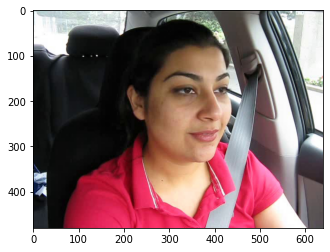

In [28]:
plt.imshow(plt.imread("/content/drive/MyDrive/Training Data/test/test/no_yawn/840.jpg"))
plt.show()

In [29]:
prediction = model.predict([prepare("/content/drive/MyDrive/Training Data/test/test/no_yawn/840.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 102ms/step


1

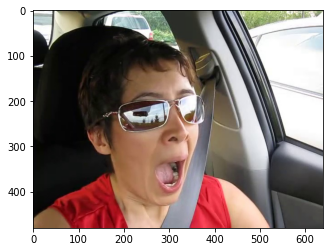

In [30]:
plt.imshow(plt.imread("/content/drive/MyDrive/Training Data/test/test/yawn/205.jpg"))
plt.show()

In [31]:
prediction = model.predict([prepare("/content/drive/MyDrive/Training Data/test/test/yawn/205.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 115ms/step


3